# Overtopping discharge predictions using machine learning algorithms

* Introduction
* Import libraries
* Load the data and prepare them
* SVR Regression
        * Hyperparameters search
        * Learning curve
        * Build the SVR model and make predictions
* Gradient boosting Regressor
        * Add validation data set
        * Hyperparameters search
        * Search the best n_estimator
        * Learning curve
        * Feature importances from the GBR model
        * Build the GBR model and make predictions
* Voting regressor
        * Set up the Voting regressor
        * Make predictions
    
    
    
    

# Introduction

The overtopping discharge is usually computed from an empirical method explains in the [Eurotop manual](http://www.overtopping-manual.com). These analytical methods are targeted to represent specific structures types, often quite simple geometries and are far from providing a complete description of all coastal structures types and performances.   

This notebook is a use case focusing on the overtopping discharge predictions with Machine learning algorithms. For the task, i use the CLASH database consisting of large number of physical model.

### Clash database

The dataset is composed for each physical run of 31 inputs described below :

<img src="./figure/CLASH_parameters_all.PNG" style="display: block;height:30%"/>

<img src="./figure/schematization_structures.PNG" style="display: block;height:15%"/>

RF indicates how reliable a test is on the basis of the available information.
CF indicates how well a structure geometry could be described by the geometrical parameters considered in the database. 

A value of 4 for RF and CF means that the test was so unreliable or so complex that it should not be considered neither for further analysis nor for training. 

### Training database

For performs the regression task, the input parameters are made dimensionless with physically based motivations. The wave overtopping discharge 'q' is also converted to dimensionless form and rescaled.


<img src="./figure/input_parameters.PNG" style="display: block;height:15%">


### Prediction models

For the task, SVr and GBr models have been trained and tested. For a better score, the combination of these models has been set up with a voting regressor.

# Import libraries

In [85]:
# import libraries

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor

import warnings
warnings.filterwarnings('ignore')

# Load the data and prepare them 

In [74]:
#load data
df= pd.read_excel('Database.xls')
df.head()

,Name,Hm0 deep,Tp deep,Tm deep,"Tm-1,0 deep",h deep,m,b,h,Hm0 toe,...,tanaB,Bh,Ac,Gc,RF,CF,q,Pow,Remark,Reference
0,NaN,m,s,s,s,m,NaN,°,m,m,...,NaN,m,m,m,NaN,NaN,m3/s/m,%,NaN,NaN
1,001-001,0.1075,1.591304,1.326087,1.44664,0.184375,42.857143,0,0.033125,0.024,...,0.0,0,0.060625,0.431875,4.0,3.0,0.000111,NaN,NaN,NaN
2,001-002,0.1075,1.591304,1.326087,1.44664,0.193125,25.000000,0,-0.020625,NaN,...,0.0,0,0.051875,0.431875,4.0,3.0,0.000144,NaN,NaN,NaN
3,001-003,0.12625,2.086957,1.73913,1.897233,0.21125,42.857143,0,0.06,0.045,...,0.0,0,0.03375,0.431875,4.0,3.0,0.000594,NaN,NaN,NaN
4,001-004,0.12625,2.086957,1.73913,1.897233,0.21125,25.000000,0,-0.0025,NaN,...,0.0,0,0.03375,0.431875,4.0,3.0,0.000625,NaN,NaN,NaN


In [75]:
#create delete list for parameters unused
delete_list = ['Name',
               'Hm0 deep',
               'Tp deep',
               'Tm deep',
               'Tm-1,0 deep',
               'h deep',
               'Tm toe',
               'Tm-1,0 toe',
               'cotau',
               'cotaexcl',
               'tanaB',
               'RF',
               'CF',
               'Pow',
               'Remark',
               'Reference']

# delete simulation with RF and CD = 4. Theses simulations correspond to complex structures  
df.drop(df.index[df['RF'] == 4], inplace=True)
df.drop(df.index[df['CF'] == 4], inplace=True)

# delete the firts line - corresponding to units
df.drop(df.head(1).index, inplace=True)

# delete the columns inside the delete list
for x in delete_list:
    df = df.drop([x],axis=1)

df.head()

,m,b,h,Hm0 toe,Tp toe,ht,Bt,gf,cotad,cotaincl,Rc,B,hb,Bh,Ac,Gc,q
5,42.857143,0,0.085,0.063,2.165217,0.085,0,1.00,0.000000,0.000000,0.025,0,0,0,0.00875,0.431875,0.002063
11,42.857143,0,0.085,0.063,2.165217,0.085,0,1.00,0.000000,0.000000,0.1,0,0,0,0.03125,0.431875,0.000188
17,42.857143,0,0.085,0.063,2.165217,0.085,0,1.00,0.000000,0.000000,0.025,0,0,0,0.08375,0.431875,0.000406
25,66.000000,0,0.326154,0.081231,1.958509,0.218462,0.184615,0.55,1.333333,1.333333,0.273846,0,0,0,0.215385,0.076923,0
26,66.000000,0,0.326154,0.152308,1.665648,0.218462,0.184615,0.55,1.333333,1.333333,0.273846,0,0,0,0.215385,0.076923,0.000203


In [76]:
# convert in float
df = df.astype('float')

# delete the NaN 
df = df.dropna()

# delete all the simulation with an overtoping discharge less than 0.000001
df.drop(df.index[df['q'] < 0.000001], inplace=True)

In [77]:
# compute spectral wave length in deep water lm0 in meter
df['Lm0'] = ((9.8*(df['Tp toe'])**2)/(2*np.pi))

# create dataframe containing the model parameters
dff = pd.DataFrame({
    'Hm0' :df['Hm0 toe'],
    'Hm0/Lm0':df['Hm0 toe']/df['Lm0'],
    'b':df['b'],
    'h/Lm0':df['h']/df['Lm0'],
    'ht/Hm0':df['ht']/df['Hm0 toe'],
    'Bt/Lm0':df['Bt']/df['Lm0'],
    'hb/Hm0':df['hb']/df['Hm0 toe'],
    'B/Lm0':df['B']/df['Lm0'],
    'Ac/Hm0':df['Ac']/df['Hm0 toe'],
    'Rc/Hm0':df['Rc']/df['Hm0 toe'],
    'Gc/Lm0':df['Gc']/df['Lm0'],
    'm':df['m'],
    'cotad':df['cotad'],
    'cotaincl':df['cotaincl'],
    'gf':df['gf'],
    'q':df['q'],
    'qAD':np.log10(df['q']/np.sqrt(9.8*(df['Hm0 toe'])**3)),
    })
dff.head()

,Hm0,Hm0/Lm0,b,h/Lm0,ht/Hm0,Bt/Lm0,hb/Hm0,B/Lm0,Ac/Hm0,Rc/Hm0,Gc/Lm0,m,cotad,cotaincl,gf,q,qAD
5,0.063000,0.008616,0.0,0.011624,1.349206,0.000000,0.0,0.0,0.138889,0.396825,0.059062,42.857143,0.000000,0.000000,1.00,0.002063,-1.380230
11,0.063000,0.008616,0.0,0.011624,1.349206,0.000000,0.0,0.0,0.496032,1.587302,0.059062,42.857143,0.000000,0.000000,1.00,0.000188,-2.421623
17,0.063000,0.008616,0.0,0.011624,1.349206,0.000000,0.0,0.0,1.329365,0.396825,0.059062,42.857143,0.000000,0.000000,1.00,0.000406,-2.085830
26,0.152308,0.035197,0.0,0.075372,1.434343,0.042663,0.0,0.0,1.414141,1.797980,0.017776,66.000000,1.333333,1.333333,0.55,0.000203,-2.961179
27,0.187077,0.027070,0.0,0.047195,1.167763,0.026714,0.0,0.0,1.151316,1.463816,0.011131,66.000000,1.333333,1.333333,0.55,0.000718,-2.547617


In [78]:
# split train and set data

train_set, test_set = train_test_split(dff, test_size=0.2,random_state=42)

scaler = MinMaxScaler()
# transform data

scaler_std = StandardScaler()
train_transform = pd.DataFrame(train_set.drop(['Hm0','q','qAD'], axis=1))
train_transform = pd.DataFrame(scaler_std.fit_transform(train_transform))
train_transform.columns = train_set.drop(['Hm0','q','qAD'], axis=1).columns
test_transform = pd.DataFrame(test_set.drop(['Hm0','q','qAD'], axis=1))
test_transform = pd.DataFrame(scaler_std.transform(test_transform))
test_transform.columns = test_set.drop(['Hm0','q','qAD'], axis=1).columns


#organize the data 
train = {
    #'features': train_transform.drop(['Hm0','q','qAD','qAD'], axis=1),
    #'target' : train_transform['qAD']
    #'features': train_set.drop(['Hm0','q','qAD'], axis=1),
    'features': train_transform,
    'target' : scaler.fit_transform(train_set['qAD'].values.reshape(-1,1))
}
test = {
    #'features': test_transform.drop(['Hm0','q','qAD','qAD'], axis=1),
    #'target' : test_transform['qAD']
    #'features': test_set.drop(['Hm0','q','qAD'], axis=1),
    'features': test_transform,
    'target' : pd.DataFrame(scaler.fit_transform(test_set['qAD'].values.reshape(-1,1)))
}

# keep Hm0 data for the inverse_transform
Hm0_test = pd.DataFrame(test_set['Hm0'])

# SVR Regression


In [79]:
# functions tunning SVR hyperparamters 

def SVR_regression(params, cv, scoring, features, target):
    SVR_reg = SVR()
    for x in scoring:
        grid_search = GridSearchCV(SVR_reg,
                                   params_Grid,
                                   cv=cv,
                                   scoring=x,
                                   n_jobs=-1)
        grid_search.fit(features, target)
        print()
        print()
        print("######### Tuning hyper-parameters for %s" % x)
        print()
        print("Best parameters set found on development set:")
        if x == 'neg_mean_squared_error':
            print(grid_search.best_params_, ' -----> SCORE RMSE: %f' %
                  np.sqrt(-grid_search.best_score_))
        else:
            print(grid_search.best_params_, ' -----> SCORE: %f' %
                  grid_search.best_score_)
            
def plot_learning_curve(estimator, features, target, train_sizes):

    plt.figure(figsize=(8, 8))
    plt.title('Learning curve')
    plt.xlabel("Training examples")
    plt.ylabel("RMSE")

    estimator.fit(features, target)
    train_sizes, train_scores, validation_scores = learning_curve(
        estimator, features, target, cv=10, n_jobs=-1, train_sizes=train_sizes, scoring='neg_mean_squared_error')

    train_scores_mean = train_scores.mean(axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = validation_scores.mean(axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)
    plt.grid()
    plt.fill_between(np.sqrt(train_sizes), np.sqrt(-train_scores_mean) - np.sqrt(train_scores_std),
                     np.sqrt(-train_scores_mean) + np.sqrt(train_scores_std), color="#dddddd")
    plt.fill_between(np.sqrt(train_sizes), np.sqrt(-validation_scores_mean) - np.sqrt(validation_scores_std),
                     np.sqrt(-validation_scores_mean) + np.sqrt(validation_scores_std), color="#dddddd")
    plt.plot(np.sqrt(train_sizes), np.sqrt(-train_scores_mean), '--',
             color="k", label="Training score")
    plt.plot(np.sqrt(train_sizes), np.sqrt(-validation_scores_mean),
             color="k", label="Cross-validation score")
    plt.legend(loc="best")



### Hyperparameters search

In [25]:
# select the metrics
scoring = ['neg_mean_squared_error','r2']

# research parameters 
params_Grid = {'kernel': ['rbf'],
               'C': [10,11],
               'epsilon' : [0.02,0.03]
               }

# run GridSearchCV for find the best parameters 
SVR_regression(params_Grid, 5, scoring, train['features'], train['target'].ravel())



######### Tuning hyper-parameters for neg_mean_squared_error

Best parameters set found on development set:
{'C': 10, 'epsilon': 0.02, 'kernel': 'rbf'}  -----> SCORE RMSE: 0.060558


######### Tuning hyper-parameters for r2

Best parameters set found on development set:
{'C': 10, 'epsilon': 0.02, 'kernel': 'rbf'}  -----> SCORE: 0.866230


### Learning curve

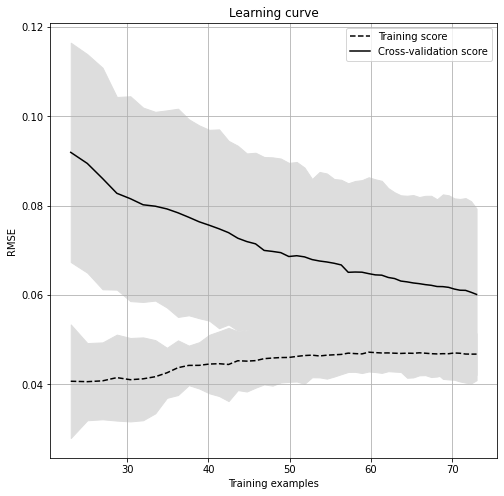

In [26]:
# plot the learning curve for check the model response

SVR_reg = SVR(kernel='rbf',
              C = 10,
              epsilon = 0.02)
plot_learning_curve(SVR_reg,train['features'], train['target'].ravel(),train_sizes = np.linspace(0.1, 1, 50))

### Build the SVR model and make predictions

In [80]:
# build the model with the hyperparameters tuning
SVR_reg = SVR(kernel='rbf',
              C = 10,
              epsilon = 0.02)

SVR_reg.fit(train['features'], train['target'])
prediction = SVR_reg.predict(test['features'])
test['predictions'] = pd.DataFrame(prediction)

In [28]:
print("############## SCORE DATASET TEST FOR SUPPORT VECTOR REGRESSION ########")
print()
print("R2 TEST")
print(r2_score(test['target'], test['predictions']))
print()
print("RMSE TEST")
print(np.sqrt(mean_squared_error(test['target'], test['predictions']))) 

############## SCORE DATASET TEST FOR SUPPORT VECTOR REGRESSION ########

R2 TEST
0.8618473700622622

RMSE TEST
0.06270974713237393


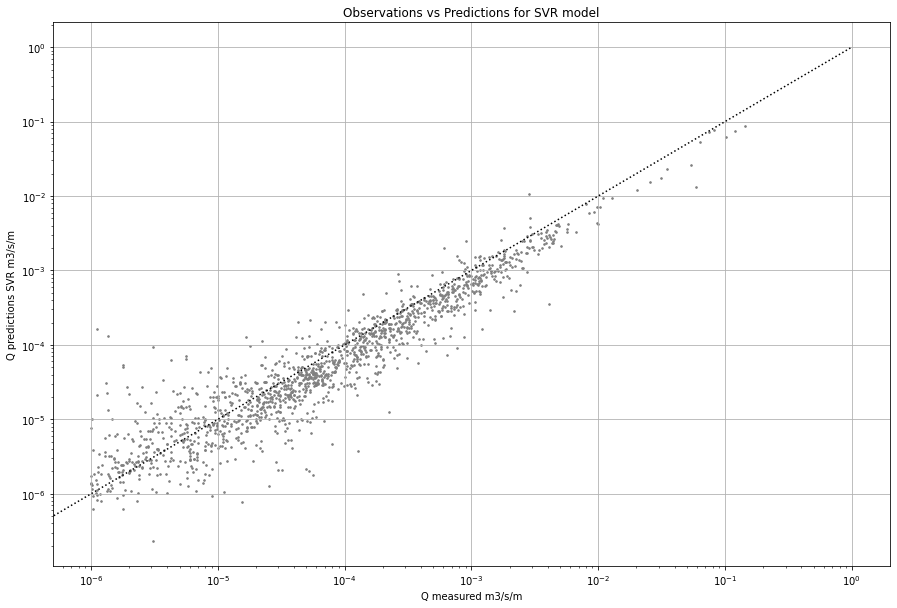

In [91]:
# plot the SVR predictions vs Observation from the test set

def transform(Hm0, data,scaler):
    prediction = scaler.inverse_transform(data.values.reshape(-1,1))
    q_overtopping = (10**(prediction.flatten()))*np.sqrt(9.8*(Hm0_test['Hm0'])**3)
    return q_overtopping

fig = plt.figure(figsize=(15,10))
plt.title('Observations vs Predictions for SVR model')
plt.xlabel("Q measured m3/s/m"), plt.ylabel("Q predictions SVR m3/s/m")
plt.scatter(transform(Hm0_test, test['target'],scaler),
            transform(Hm0_test, test['predictions'],scaler),
            s = 10,marker = '.',c='gray',
           )
plt.plot(np.linspace(0, 1),
         np.linspace(0, 1), ':k')
#plt.axis([0.00000001, 1, 0.00000001, 1])
plt.loglog()
plt.grid()


 ## Gradient boosting Regressor


### Add validation data set

In [11]:
# split the train set between train and validation set
train_feature_GBR, train_val_feature_GBR, train_target_GBR, train_val_target_GBR = train_test_split(train['features'], train['target'], test_size=0.2,random_state=42)
train['features_GBR'] = train_feature_GBR
train['target_GBR'] = train_target_GBR
train['val_feature_GBR'] = train_val_feature_GBR
train['val_target_GBR'] = train_val_target_GBR

### Hyperparameters search

In [26]:
# buidl function for hyperparameters search

def GradientBoostR(params, cv, scoring, features, target):

    GBR = GradientBoostingRegressor(random_state=42)

    for x in scoring:
        grid_search = GridSearchCV(estimator=GBR,
                                   cv=cv,
                                   param_grid=params,
                                   n_jobs=-1,
                                   scoring=x
                                   )
        grid_search.fit(features, target)
        print()
        print("######### Tuning hyper-parameters for %s" % x)
        print()
        print()
        print("Best parameters set found on development set:")
        if x == 'neg_mean_squared_error':
            print(grid_search.best_params_, ' -----> SCORE RMSE: %f' %
                  np.sqrt(-grid_search.best_score_))
        else:
            print(grid_search.best_params_, ' -----> SCORE: %f' %
                  grid_search.best_score_)

In [33]:
# search hyperparameters

scoring = ['neg_mean_squared_error',
          'r2'
          ]
           

params_Grid = {'learning_rate': [0.1],
               'max_depth': [6,7,8,8,9],
               #'min_samples_leaf': [6, 7, 8],
               #'max_features': [5,6,7,8,9],
               'n_estimators': [100]
               }

GradientBoostR(params_Grid, 5, scoring, train['features'], train['target'].ravel())


######### Tuning hyper-parameters for neg_mean_squared_error


Best parameters set found on development set:
{'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 100}  -----> SCORE RMSE: 0.056445

######### Tuning hyper-parameters for r2


Best parameters set found on development set:
{'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 100}  -----> SCORE: 0.883745


### Search the best n_estimator

Text(0.5, 1.0, 'Validation error')

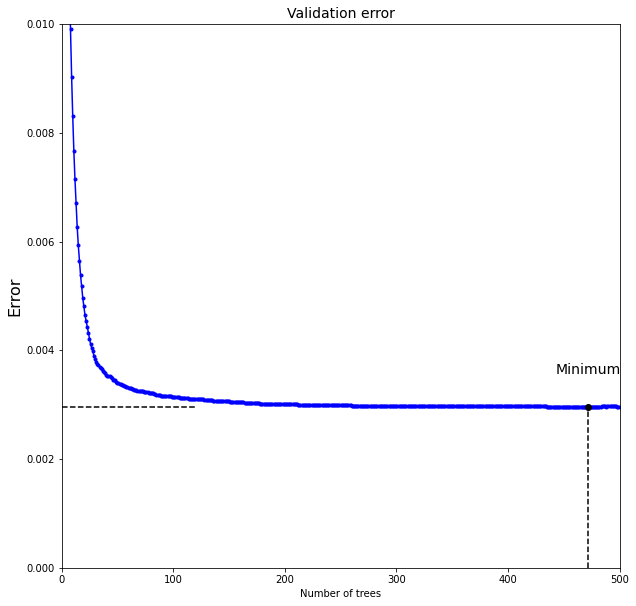

In [39]:
# search best n_estimators

GBR = GradientBoostingRegressor( max_depth=8, n_estimators=500, learning_rate=0.1)
GBR.fit(train['features_GBR'],train['target_GBR'])

errors = [mean_squared_error(train['val_target_GBR'], prediction)
          for prediction in GBR.staged_predict(train['val_feature_GBR'])]

bst_n_estimators = np.argmin(errors) + 1

GBR_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
GBR_best.fit(train['features_GBR'], train['target_GBR'])

#plot validation error for the n_estimators
min_error = np.min(errors)
plt.figure(figsize=(10, 10))
plt.plot(np.arange(1, len(errors) + 1), errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 500, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)


### Learning curve

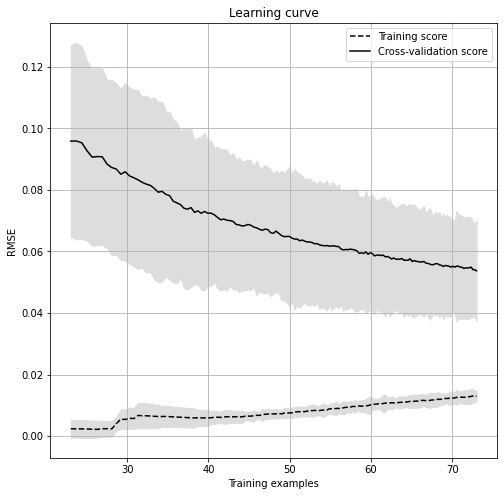

In [100]:
# learning curve regarding GBR model
GBR = GradientBoostingRegressor(learning_rate=0.1,
                                max_depth=8,
                                n_estimators=333,
                                random_state=42)


plot_learning_curve(GBR,train['features'], train['target'].ravel(),train_sizes = np.linspace(0.1, 1, 150))

###  Feature importances from the GBR model

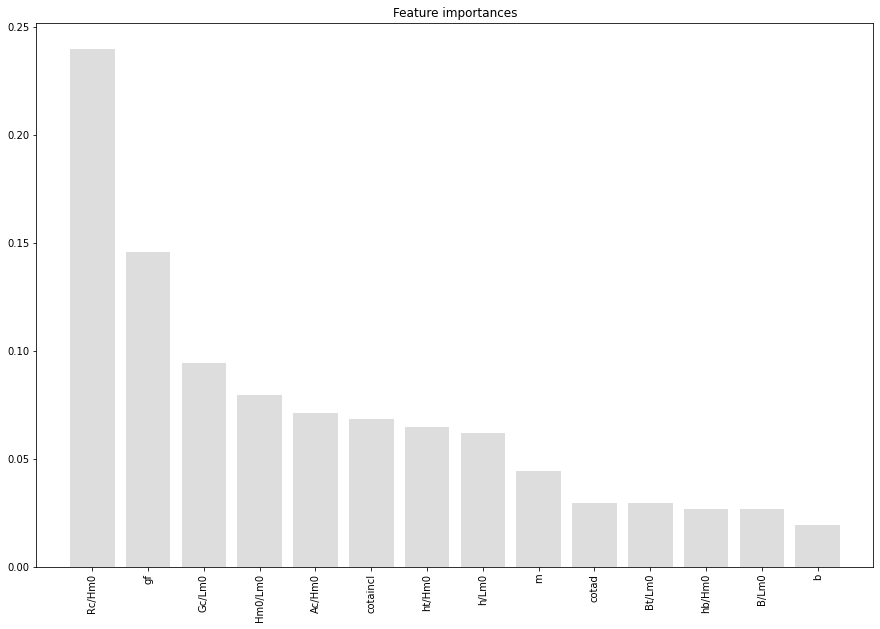

In [94]:
# check the feature importance

def features_importances(estimator, features):
    importances = estimator.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(15, 10))
    plt.title("Feature importances")
    plt.bar(range(len(importances)),
            importances[indices], color="#dddddd", align="center")
    plt.xticks(range(len(importances)),
               features.columns[indices], fontsize=10, rotation=90)
    plt.xlim([-1, len(importances)])
    plt.show()
    
features_importances(GBR,train['features'])

### Build the GBR model and make predictions

In [93]:
# run GBR with best parameters
# add stochastic gradient boosting => reduce Std but increase biais.
GBR = GradientBoostingRegressor(learning_rate=0.1,
                                max_depth=8,
                                n_estimators=333,
                                subsample=0.25,
                                random_state=42)
GBR.fit(train['features'], train['target'].ravel())

prediction = GBR.predict(test['features'])
test['predictions'] = pd.DataFrame(prediction)

print("############## SCORE DATASET TEST FOR GBR ########")
print()
print("R2 TEST")
print(r2_score(test['target'], test['predictions']))
print()
print("RMSE TEST")
print(np.sqrt(mean_squared_error(test['target'], test['predictions'])))          

############## SCORE DATASET TEST FOR GBR ########

R2 TEST
0.8699051507521365

RMSE TEST
0.0608534944591318


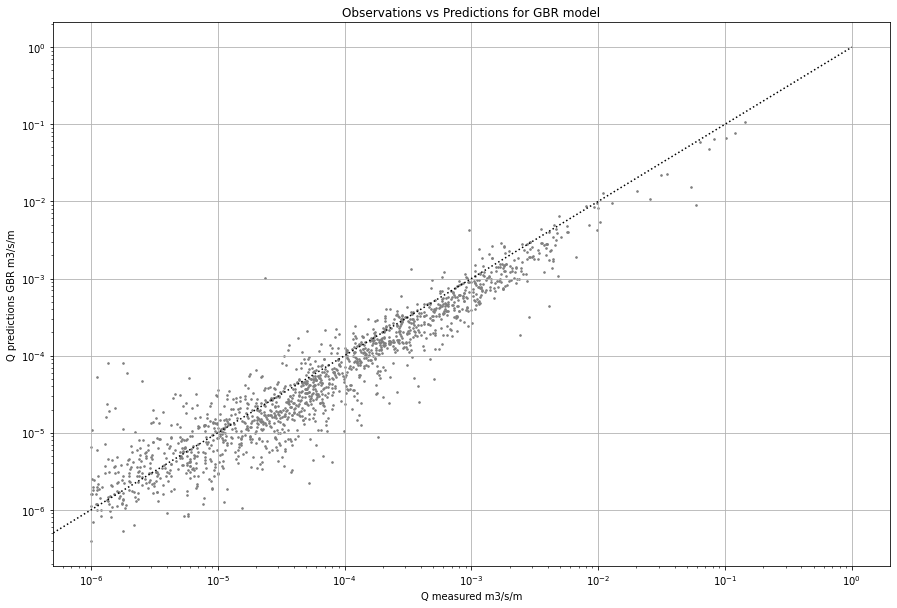

In [95]:
def transform(Hm0, data,scaler):
    prediction = scaler.inverse_transform(data.values.reshape(-1,1))
    q_overtopping = (10**(prediction.flatten()))*np.sqrt(9.8*(Hm0_test['Hm0'])**3)
    return q_overtopping

fig = plt.figure(figsize=(15,10))
plt.title('Observations vs Predictions for GBR model')
plt.xlabel("Q measured m3/s/m"), plt.ylabel("Q predictions GBR m3/s/m")
plt.scatter(transform(Hm0_test, test['target'],scaler),
            transform(Hm0_test, test['predictions'],scaler),
            s = 10,marker = '.',c='gray',
           )
plt.plot(np.linspace(0, 1),
         np.linspace(0, 1), ':k')
#plt.axis([0.00000001, 1, 0.00000001, 1])
plt.loglog()
plt.grid()

# GBR model vs SVR model

Compare the score and predictions from theses models

In [59]:
GBR = GradientBoostingRegressor(learning_rate=0.1,
                                max_depth=8,
                                n_estimators=333,
                                subsample=0.25,
                                random_state=42)
GBR.fit(train['features'], train['target'].ravel())

prediction = GBR.predict(test['features'])
test['predictions_GBR'] = pd.DataFrame(prediction)

SVR_reg = SVR(kernel='rbf',
              C = 10,
              epsilon = 0.02)

SVR_reg.fit(train['features'], train['target'])
prediction = SVR_reg.predict(test['features'])
test['predictions_SVR'] = pd.DataFrame(prediction)

print("############## SCORE DATASET TEST FOR GBR ########")
print()
print("R2 TEST")
print(r2_score(test['target'], test['predictions_GBR']))
print()
print("RMSE TEST")
print(np.sqrt(mean_squared_error(test['target'], test['predictions_GBR'])))
print('')
print("############## SCORE DATASET TEST FOR SUPPORT VECTOR REGRESSION ########")
print()
print("R2 TEST")
print(r2_score(test['target'], test['predictions_SVR']))
print()
print("RMSE TEST")
print(np.sqrt(mean_squared_error(test['target'], test['predictions_SVR']))) 

############## SCORE DATASET TEST FOR GBR ########

R2 TEST
0.8699051507521365

RMSE TEST
0.0608534944591318

############## SCORE DATASET TEST FOR SUPPORT VECTOR REGRESSION ########

R2 TEST
0.8618473700622622

RMSE TEST
0.06270974713237393


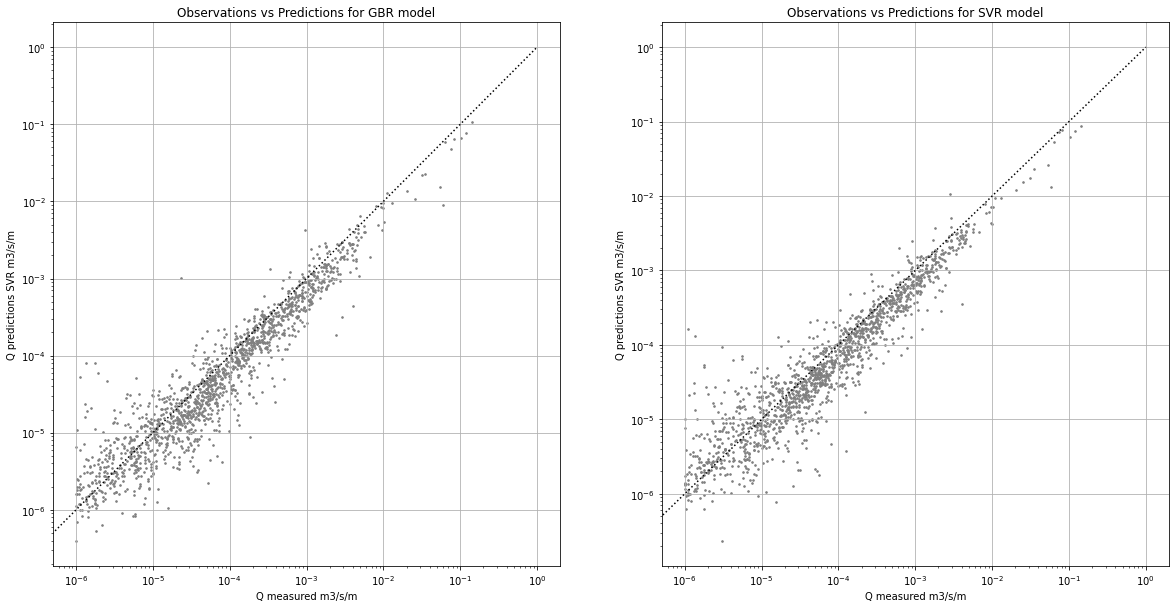

In [60]:
fig = plt.subplots(figsize=(20,10))

plt.subplot(121)
plt.title('Observations vs Predictions for GBR model')
plt.xlabel("Q measured m3/s/m"), plt.ylabel("Q predictions SVR m3/s/m")
plt.scatter(transform(Hm0_test, test['target'],scaler),
            transform(Hm0_test, test['predictions_GBR'],scaler),
            s = 10,marker = '.',c='gray',
           )
plt.plot(np.linspace(0, 1),
         np.linspace(0, 1), ':k')
#plt.axis([0.00000001, 1, 0.00000001, 1])
plt.loglog()
plt.grid()

plt.subplot(122)
plt.title('Observations vs Predictions for SVR model')
plt.xlabel("Q measured m3/s/m"), plt.ylabel("Q predictions SVR m3/s/m")
plt.scatter(transform(Hm0_test, test['target'],scaler),
            transform(Hm0_test, test['predictions_SVR'],scaler),
            s = 10,marker = '.',c='gray',
           )
plt.plot(np.linspace(0, 1),
         np.linspace(0, 1), ':k')
#plt.axis([0.00000001, 1, 0.00000001, 1])
plt.loglog()
plt.grid()

# Voting regressor

Using voting regressor for combine the SVR and GBR predictions

### Set up the Voting regressor

In [87]:
GBR = GradientBoostingRegressor(learning_rate=0.1,
                                max_depth=8,
                                n_estimators=333,
                                subsample=0.25,
                                random_state=42)
SVR_reg = SVR(kernel='rbf',
              C = 10,
              epsilon = 0.02)

voting = VotingRegressor(
    estimators=[('gbr', GBR), ('svr', SVR_reg)])

voting.fit(train['features'], train['target'].ravel())

VotingRegressor(estimators=[('gbr',
                             GradientBoostingRegressor(max_depth=8,
                                                       n_estimators=333,
                                                       random_state=42,
                                                       subsample=0.25)),
                            ('svr', SVR(C=10, epsilon=0.02))])

### Make predictions

In [88]:
prediction = voting.predict(test['features'])
test['predictions_voting'] = pd.DataFrame(prediction)

print("############## SCORE DATASET TEST FOR VOTING ########")
print()
print("R2 TEST")
print(r2_score(test['target'], test['predictions_voting']))
print()
print("RMSE TEST")
print(np.sqrt(mean_squared_error(test['target'], test['predictions_voting'])))


############## SCORE DATASET TEST FOR VOTING ########

R2 TEST
0.8837752965367686

RMSE TEST
0.057518121593019625


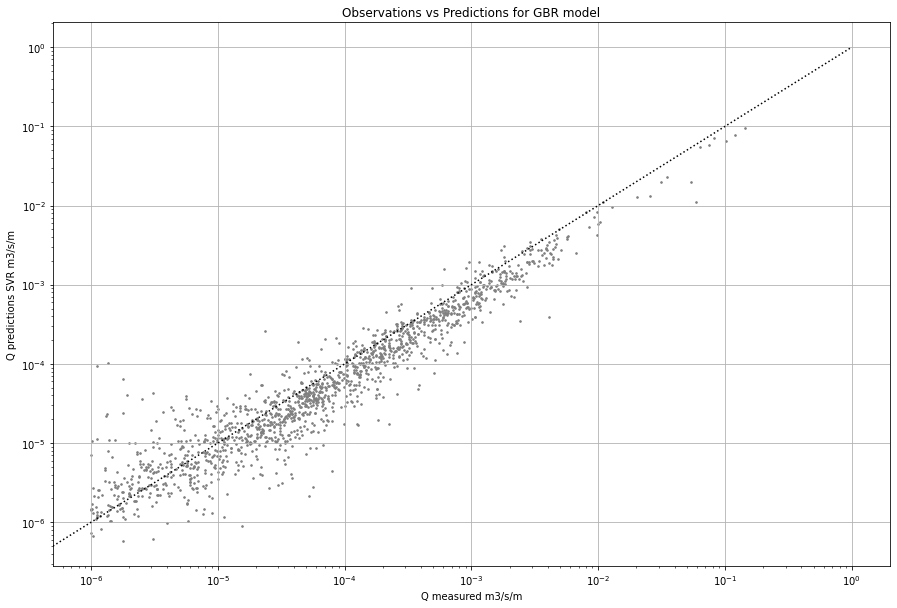

In [90]:
fig = plt.subplots(figsize=(15,10))

plt.title('Observations vs Predictions for GBR model')
plt.xlabel("Q measured m3/s/m"), plt.ylabel("Q predictions SVR m3/s/m")
plt.scatter(transform(Hm0_test, test['target'],scaler),
            transform(Hm0_test, test['predictions_voting'],scaler),
            s = 10,marker = '.',c='gray',
           )
plt.plot(np.linspace(0, 1),
         np.linspace(0, 1), ':k')
#plt.axis([0.00000001, 1, 0.00000001, 1])
plt.loglog()
plt.grid()
